git checkout -b dummy #commit hash
git delete branch

In [1]:
from __future__ import annotations
import os
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import time
from tqdm import tqdm

import torch
import torch.distributed as dist
import torch.nn.functional as F
from torch.nn.parallel import DistributedDataParallel

from app.vjepa.transforms import make_transforms
import root.args as parser #import _parse_args, _resolve_sampling_kwargs
from root.models.model import _build_model
import root.utils as utils
import root.dataset as dataset
from root.ddp import _wrap_ddp, _ddp_mean, _is_distributed
from src.datasets.video_dataset import make_videodataset
from src.utils.distributed import init_distributed
from src.utils.logging import AverageMeter, get_logger
import json
import argparse

logger = get_logger(__name__, force=True)

In [2]:
@torch.no_grad()
def run_validation(
    model: torch.nn.Module,
    loader,
    device: torch.device,
    world_size: int,
    *,
    epoch: int,
    step: int,
    is_master: bool,
) -> tuple[float, float]:
    model.eval()
    if hasattr(model, "collect_update_gates"):
        model.collect_update_gates = True
    correct = torch.tensor(0.0, device=device)
    total = torch.tensor(0.0, device=device)
    loss_sum = torch.tensor(0.0, device=device)

    for batch in tqdm(utils._iter_batches(loader), total=len(loader), desc=f"Validating epoch {epoch}"):
        clips = batch.clips
        ds_index = batch.ds_index
        x = clips[0] if isinstance(clips, (list, tuple)) else clips
        x = x.to(device, non_blocking=True)
        y = batch.labels.to(device=device, dtype=torch.long, non_blocking=True)
        logits = model(x, ds_index)
        if model.cache_dino_feats:
            continue
        loss_sum += F.cross_entropy(logits, y, reduction="sum")
        pred = logits.argmax(dim=1)
        correct += (pred == y).float().sum()
        total += float(y.numel())
    
    if model.cache_dino_feats:
        save_path = "/data3/mgaur/ssv2/dino_feats/vits14/validation.pt"
        print(f"Saving dino feats to {save_path}")
        torch.save(model.id_to_feat, save_path)                                              
        exit()

    if _is_distributed(world_size):
        dist.all_reduce(correct, op=dist.ReduceOp.SUM)
        dist.all_reduce(total, op=dist.ReduceOp.SUM)
        dist.all_reduce(loss_sum, op=dist.ReduceOp.SUM)

    acc = (correct / total.clamp_min(1.0)).item()
    mean_loss = (loss_sum / total.clamp_min(1.0)).item()
    # if is_master and wandb.run:
    #     wandb.log({
    #         "eval/loss": mean_loss,
    #         "eval/acc": acc,
    #     }, step=global_vars["global_step"])
    if hasattr(model, "collect_update_gates"):
        model.collect_update_gates = False
    # model.train()
    return mean_loss, acc

In [3]:
# import subprocess
# import os

# commit_hash = "a1b2c3d"
# worktree_path = os.path.abspath(f"../temp_{commit_hash}") # Define the temporary folder path
# subprocess.run(["git", "worktree", "add", "--detach", worktree_path, commit_hash]) # 1. Create worktree (detached state)

# # # 2. Run the eval script inside that folder
# # # 'cwd' sets the working directory for this command only
# # subprocess.run(["python", "eval.py", "--checkpoint", ckpt_path], cwd=worktree_path)

# # 3. Force remove the worktree
# subprocess.run(["git", "worktree", "remove", "--force", worktree_path])


checkpoint_name = 'LoadCachedVitS_NoReset_GLU>FFN>Lin_dcfv33tc'
output_dir = f"/data3/mgaur/vjepa2"
config = json.load(open(os.path.join(output_dir, checkpoint_name, "config.json"), "r"))
args = utils.dict_to_namespace(config)


In [4]:
# torchrun compatibility: prefer env vars if available, but still call repo helper.
env_rank = utils._env_int("RANK", None)
env_world = utils._env_int("WORLD_SIZE", None)
world_size, rank = init_distributed(port=args.dist_port, rank_and_world_size=(env_rank, env_world))

device = utils._get_device()
if device.type == "cuda":
    torch.backends.cudnn.benchmark = True

is_master = rank == 0
logger.info(f"Initialized device={device}, rank/world={rank}/{world_size}")

# --- data
if args.cache_dino_feats:
    mode = "eval" #when load_cache_feats=true, transforms not called, automatically eval mode
else:
    mode = "train"
train_transform = make_transforms(mode=mode, crop_size=args.crop_size)
eval_transform = make_transforms(mode="eval", crop_size=args.crop_size)
sampling_kwargs = parser._resolve_sampling_kwargs(args)


train_ds, train_loader, train_sampler, val_ds, val_loader, val_sampler = dataset.get_loaders(args, train_transform, eval_transform, sampling_kwargs, rank, world_size, is_master)
args.val_dataset_len = len(val_ds)

# --- model / opt
model = _build_model(args, device)
model = _wrap_ddp(model, device, world_size)
checkpoint = torch.load(os.path.join(output_dir, checkpoint_name, "best.pt"), weights_only=False)
model.load_state_dict(checkpoint["model"])

[INFO    ][2026-01-28 00:21:54][root                ][init_distributed         ] SLURM vars not set (distributed training not available)
[INFO    ][2026-01-28 00:21:54][__main__            ][<module>                 ] Initialized device=cuda:0, rank/world=0/1
[INFO    ][2026-01-28 00:22:33][root                ][make_videodataset        ] VideoDataset dataset created
[INFO    ][2026-01-28 00:22:33][root                ][make_videodataset        ] VideoDataset unsupervised data loader created
[INFO    ][2026-01-28 00:22:38][root                ][make_videodataset        ] VideoDataset dataset created
[INFO    ][2026-01-28 00:22:38][root                ][make_videodataset        ] VideoDataset unsupervised data loader created


<All keys matched successfully>

In [ ]:
model.eval()
with torch.no_grad():
    loss, acc = run_validation(model, val_loader, device, world_size, epoch=0, step=0, is_master=is_master)

if _is_distributed(world_size):
    dist.destroy_process_group()

print(f"acc: {acc}")
print(f"loss: {loss}")

In [9]:
model.val_update_gates.mean(0)

tensor([0.5519, 0.5728, 0.5957, 0.6014, 0.5903, 0.5681, 0.5433, 0.5283])

In [10]:
for _ , max_val in enumerate(model.val_update_gates.max(0)[0]):
    print(f"t={_}:  {max_val:.2f}")

t=0:  0.72
t=1:  0.77
t=2:  0.77
t=3:  0.81
t=4:  0.81
t=5:  0.79
t=6:  0.78
t=7:  0.76


In [11]:
for _ , min_val in enumerate(model.val_update_gates.min(0)[0]):
    print(f"t={_}:  {min_val:.2f}")

t=0:  0.36
t=1:  0.37
t=2:  0.38
t=3:  0.38
t=4:  0.36
t=5:  0.34
t=6:  0.33
t=7:  0.32


### helper functions

In [7]:
idx2label ={int(v) : k for k,v in json.load(open("/data3/mgaur/ssv2/labels/labels.json", "r")).items()}

data = []
with open("/data3/mgaur/ssv2/data/validation.csv", "r") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        path, num = line.rsplit(maxsplit=1)  # robust even if path has spaces
        data.append((path, int(num)))


In [8]:
from matplotlib import pyplot as plt
import random
def visualize_frames(images):
    # images: (C, T, H, W)
    frames = images
    
    if hasattr(frames, "detach"):
        frames = frames.detach().cpu()

    # ImageNet mean/std (adjust if your pipeline uses different values)
    mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None, None]
    std  = torch.tensor([0.229, 0.224, 0.225])[:, None, None, None]

    frames = frames * std + mean           # unnormalize
    frames = frames.clamp(0, 1)            # keep in [0,1]
    frames = frames.permute(1, 2, 3, 0)    # (T, H, W, C)

    fig, axes = plt.subplots(1, frames.shape[0], figsize=(16, 8))
    
    # Handle the case where there is only 1 frame (axes is not a list)
    if frames.shape[0] == 1:
        axes = [axes]
        
    for i, ax in enumerate(axes):
        ax.imshow(frames[i])
        ax.text(0, 0, str(i), color='white', fontsize=12, backgroundcolor='black', verticalalignment='top')
        ax.axis("off")
        
    plt.tight_layout()
    plt.show()

def plot_single_image(image):
    # image: (C, H, W) -> (3, 224, 224)
    if hasattr(image, "detach"):
        image = image.detach().cpu()

    # ImageNet mean/std
    mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None]
    std  = torch.tensor([0.229, 0.224, 0.225])[:, None, None]

    image = image * std + mean           # unnormalize
    image = image.clamp(0, 1)            # keep in [0,1]
    image = image.permute(1, 2, 0)       # (H, W, C)

    plt.imshow(image)
    plt.axis("off")
    plt.show()

### Visualize samples for which (max and min) update gates are achieved

# Max

In [12]:
# val_update_gates: shape (B, T)
val_update_gates = model.val_update_gates

# max per timestep across all videos (shape: T)
max_per_t = val_update_gates.max(dim=0).values  # or [0]

# boolean mask of where each timestep equals its max
mask = val_update_gates == max_per_t  # broadcasts to (B, T)

# indices of (video_idx, timestep) where max occurs
video_idx, timestep_idx = mask.nonzero(as_tuple=True)

unique_video_idx = video_idx.unique()

# If you want all video indices per timestep:
# per_timestep_video_indices is a list of 1D tensors, one per timestep
per_timestep_video_indices = [mask[:, t].nonzero(as_tuple=True)[0] for t in range(mask.size(1))]

In [13]:
per_timestep_video_indices

[tensor([24389]),
 tensor([9266]),
 tensor([6433]),
 tensor([10610]),
 tensor([17663]),
 tensor([15771]),
 tensor([15771]),
 tensor([15066])]

video_idx: 24389
path:/nas/manu/ssv2/20bn-something-something-v2/142652.webm
Bending something so that it deforms


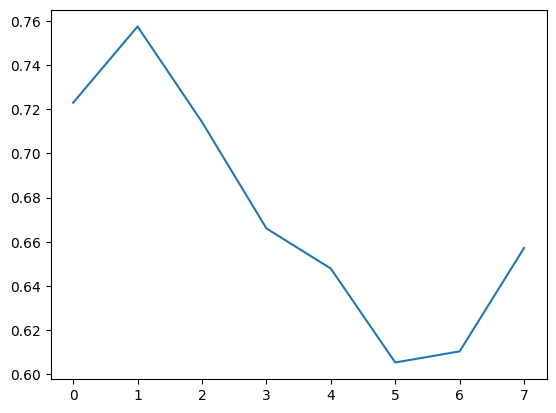

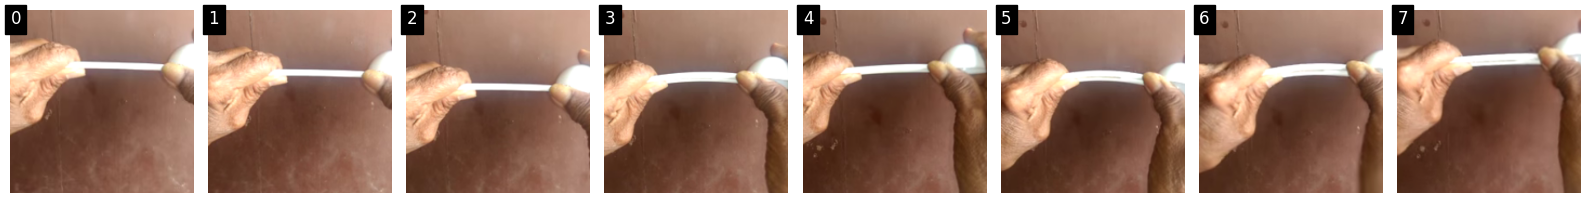

------------------------------------------------------------------------------------------
video_idx: 9266
path:/nas/manu/ssv2/20bn-something-something-v2/27141.webm
Covering something with something


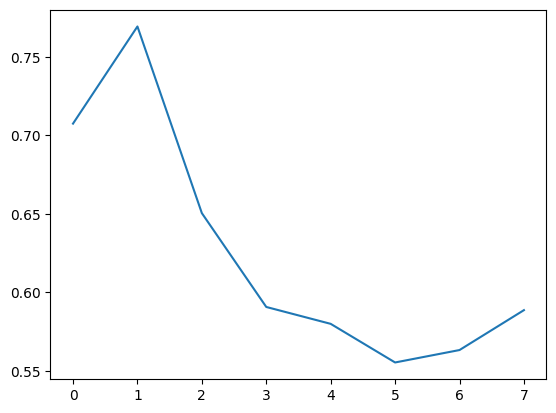

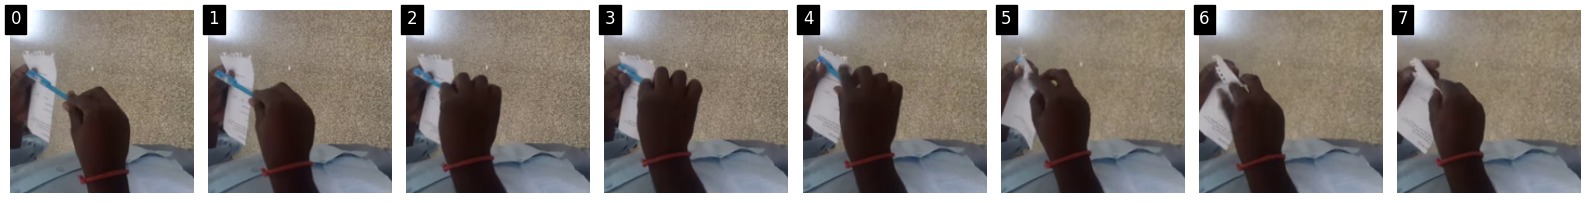

------------------------------------------------------------------------------------------
video_idx: 6433
path:/nas/manu/ssv2/20bn-something-something-v2/24315.webm
Showing that something is empty


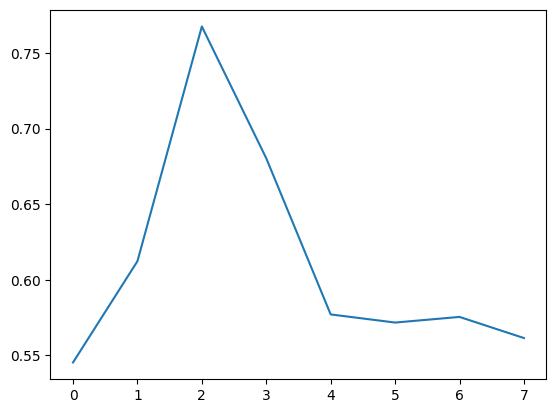

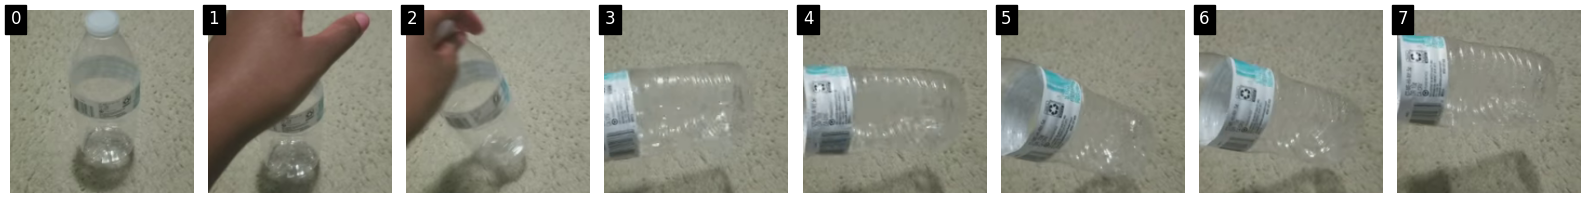

------------------------------------------------------------------------------------------
video_idx: 10610
path:/nas/manu/ssv2/20bn-something-something-v2/106988.webm
Tipping something over


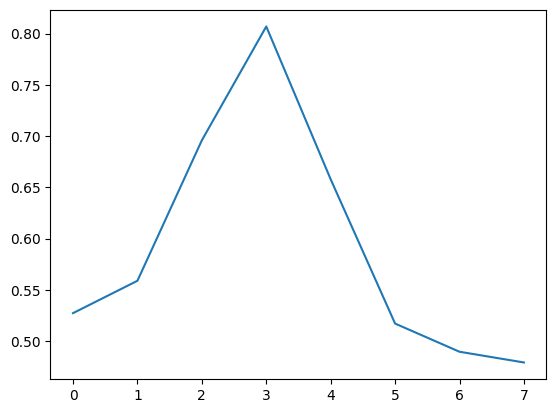

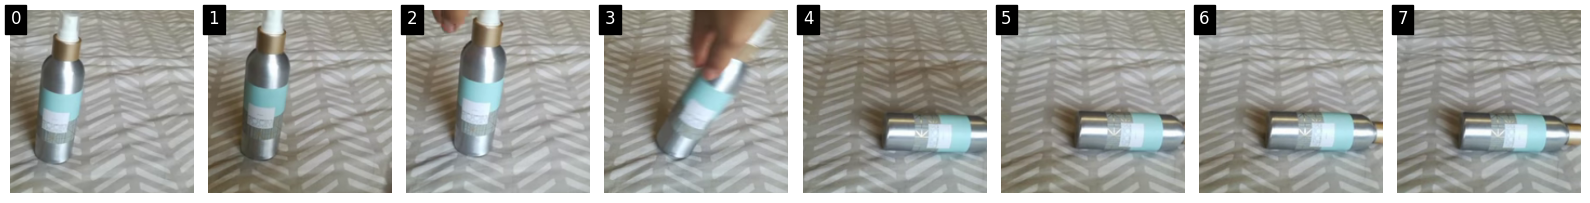

------------------------------------------------------------------------------------------
video_idx: 17663
path:/nas/manu/ssv2/20bn-something-something-v2/201066.webm
Turning something upside down


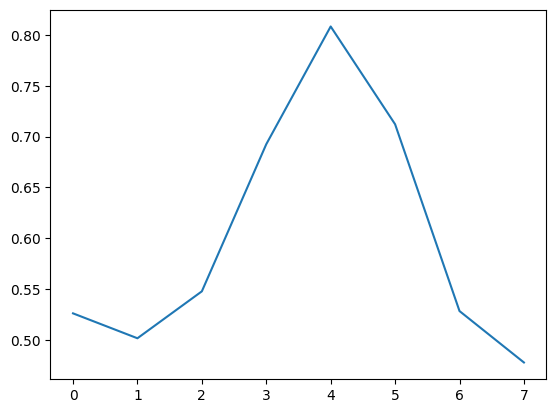

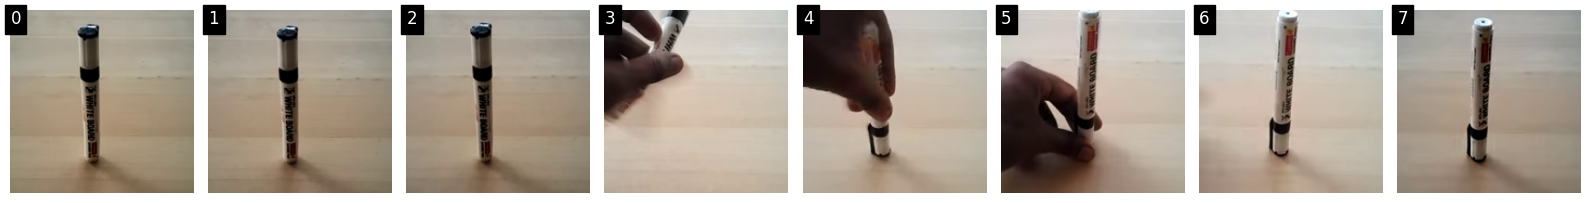

------------------------------------------------------------------------------------------
video_idx: 15771
path:/nas/manu/ssv2/20bn-something-something-v2/184864.webm
Holding something


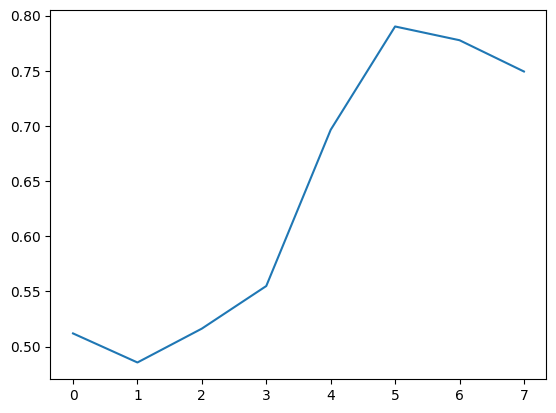

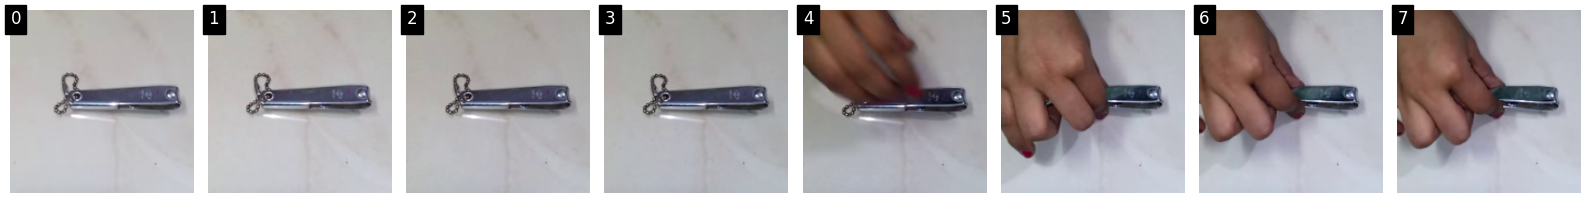

------------------------------------------------------------------------------------------
video_idx: 15771
path:/nas/manu/ssv2/20bn-something-something-v2/184864.webm
Holding something


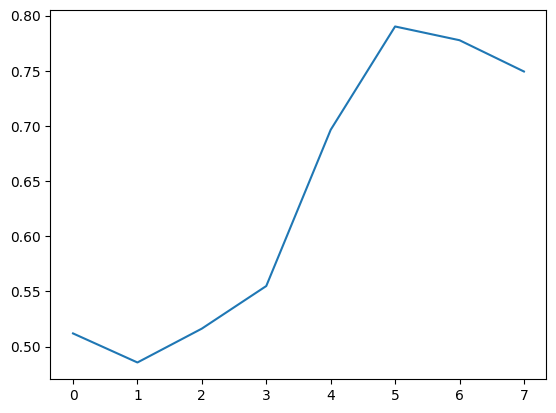

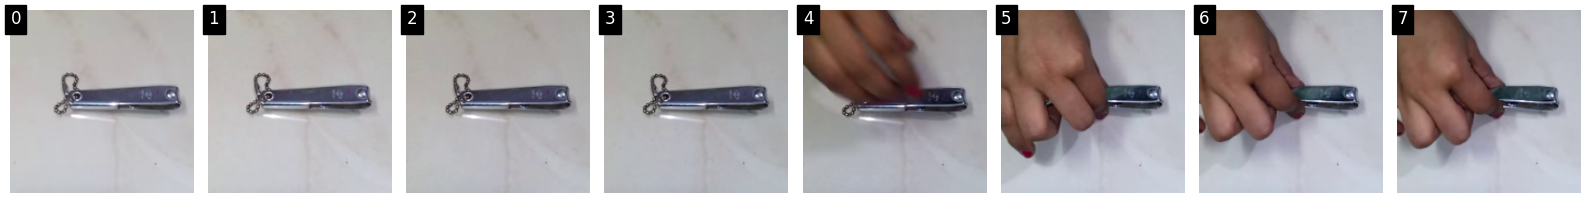

------------------------------------------------------------------------------------------
video_idx: 15066
path:/nas/manu/ssv2/20bn-something-something-v2/9991.webm
Moving something up


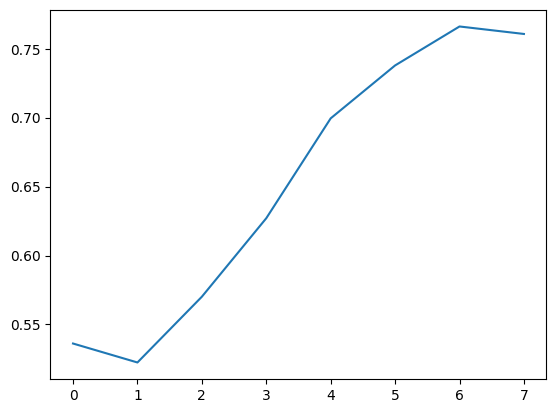

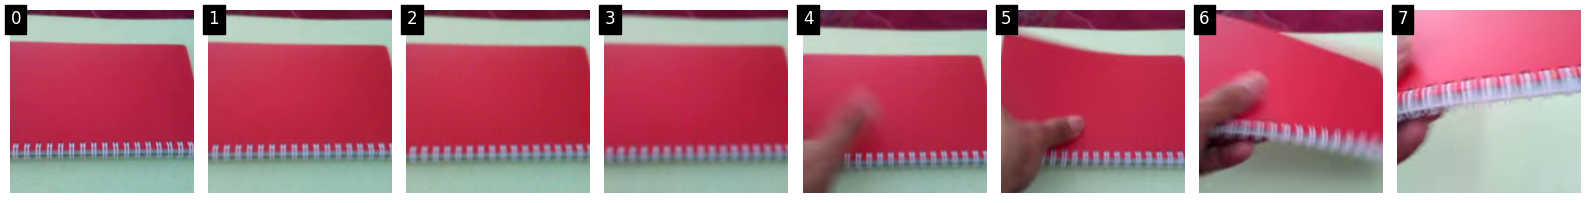

------------------------------------------------------------------------------------------


In [102]:
val_ds.load_cache_feats=False

for video_idx in per_timestep_video_indices:
    images, label, clip_indices, video_idx = val_ds.__getitem__(video_idx)
    print(f"video_idx: {video_idx.item()}")
    print(f"path:{data[video_idx][0]}")
    print(idx2label[label])
    plt.plot(val_update_gates[video_idx].tolist()[0])
    visualize_frames(images[0])
    plt.show()
    print("---"*30)


# Min

In [98]:
# val_update_gates: shape (B, T)
val_update_gates = model.val_update_gates

# min per timestep across all videos (shape: T)
min_per_t = val_update_gates.min(dim=0).values  # or [0]

# boolean mask of where each timestep equals its min
mask = val_update_gates == min_per_t  # broadcasts to (B, T)

# indices of (video_idx, timestep) where min occurs
video_idx, timestep_idx = mask.nonzero(as_tuple=True)

# unique video indices that achieve any min
unique_video_idx = video_idx.unique()

# per-timestep list of video indices
per_timestep_video_indices = [mask[:, t].nonzero(as_tuple=True)[0] for t in range(mask.size(1))]

video_idx: 4353
/nas/manu/ssv2/20bn-something-something-v2/141994.webm
Moving something and something closer to each other


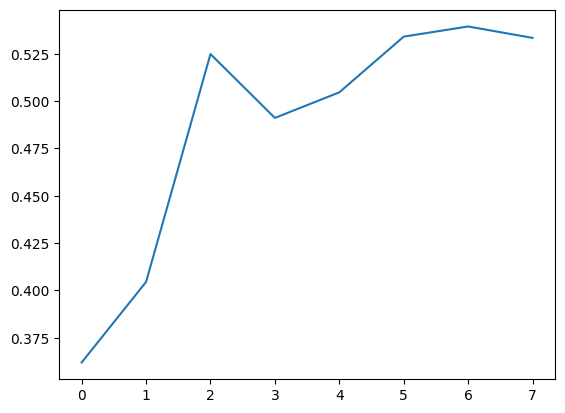

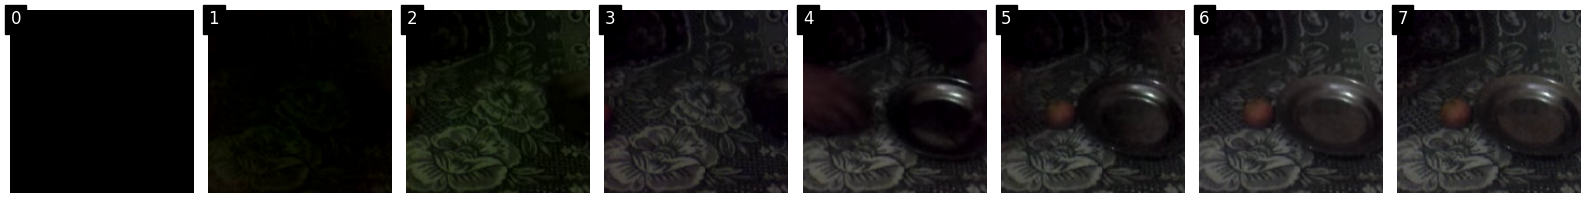

------------------------------------------------------------------------------------------
video_idx: 24764
/nas/manu/ssv2/20bn-something-something-v2/201542.webm
Uncovering something


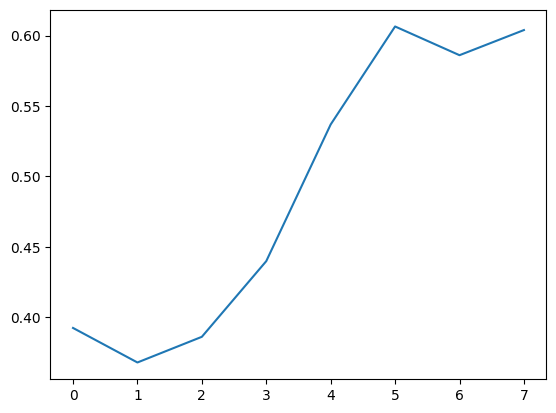

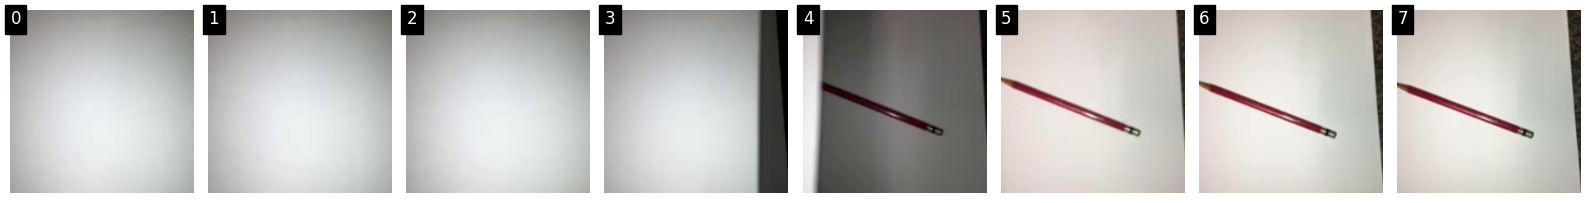

------------------------------------------------------------------------------------------
video_idx: 17255
/nas/manu/ssv2/20bn-something-something-v2/162861.webm
Tearing something into two pieces


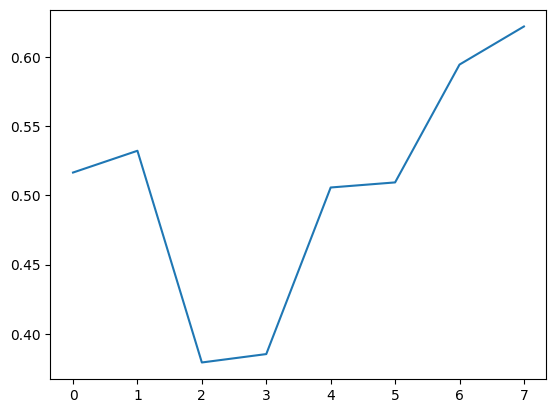

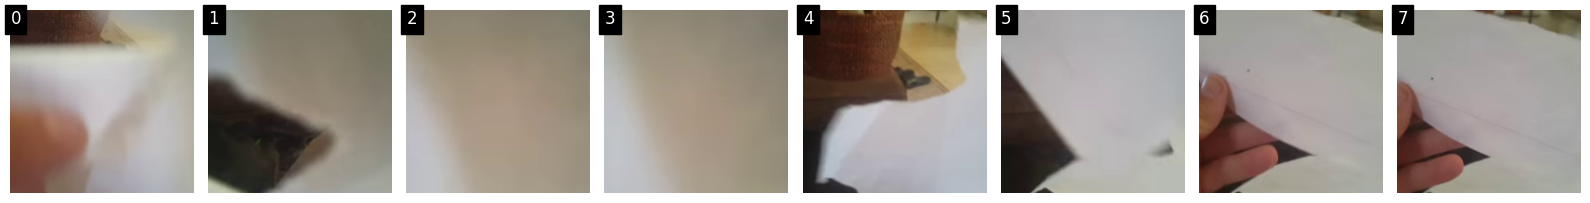

------------------------------------------------------------------------------------------
video_idx: 17101
/nas/manu/ssv2/20bn-something-something-v2/105268.webm
Something falling like a feather or paper


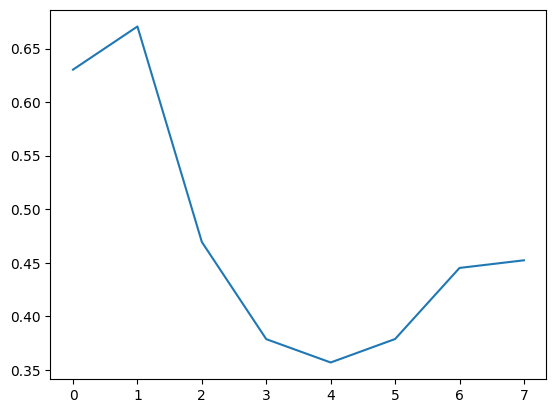

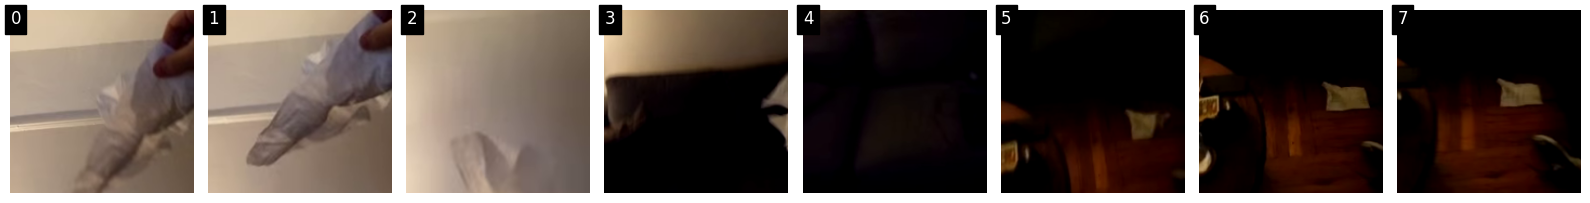

------------------------------------------------------------------------------------------
video_idx: 17101
/nas/manu/ssv2/20bn-something-something-v2/105268.webm
Something falling like a feather or paper


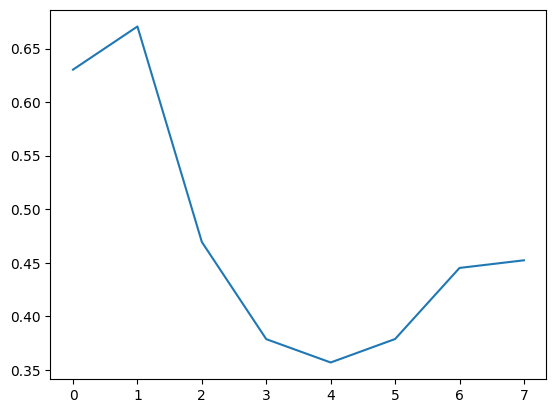

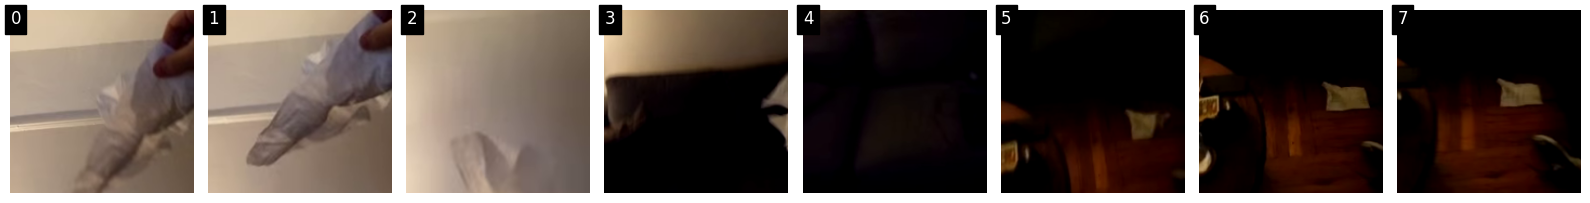

------------------------------------------------------------------------------------------
video_idx: 15699
/nas/manu/ssv2/20bn-something-something-v2/175117.webm
Letting something roll down a slanted surface


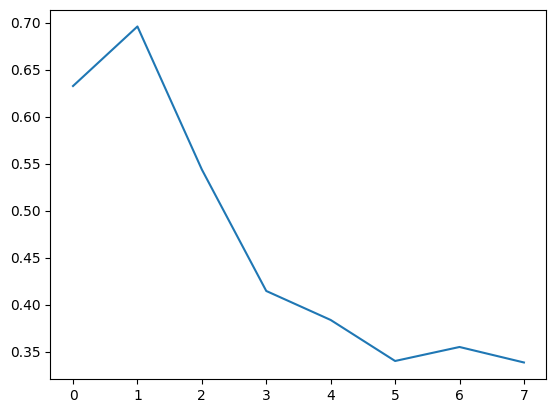

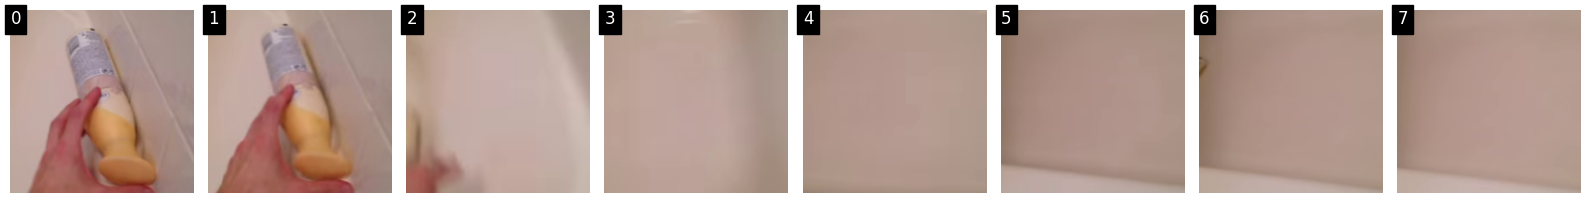

------------------------------------------------------------------------------------------
video_idx: 13872
/nas/manu/ssv2/20bn-something-something-v2/187563.webm
Something colliding with something and both are being deflected


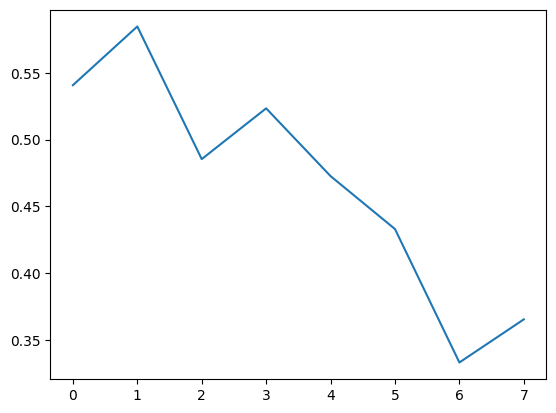

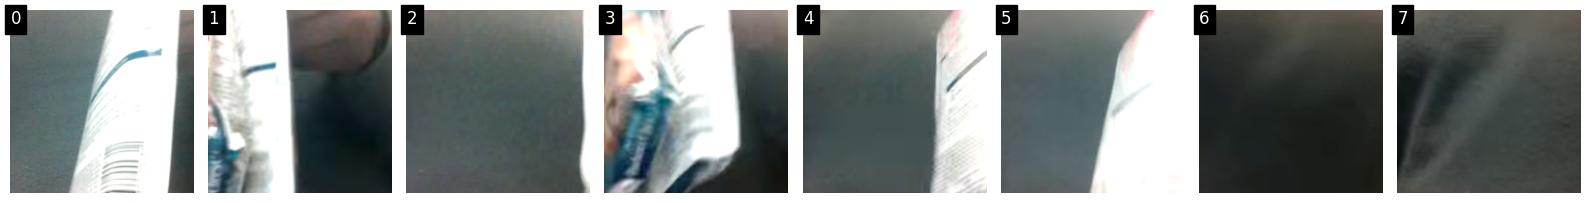

------------------------------------------------------------------------------------------
video_idx: 15531
/nas/manu/ssv2/20bn-something-something-v2/135528.webm
Something colliding with something and both come to a halt


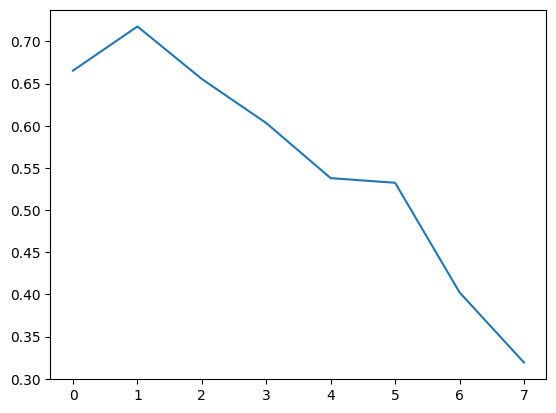

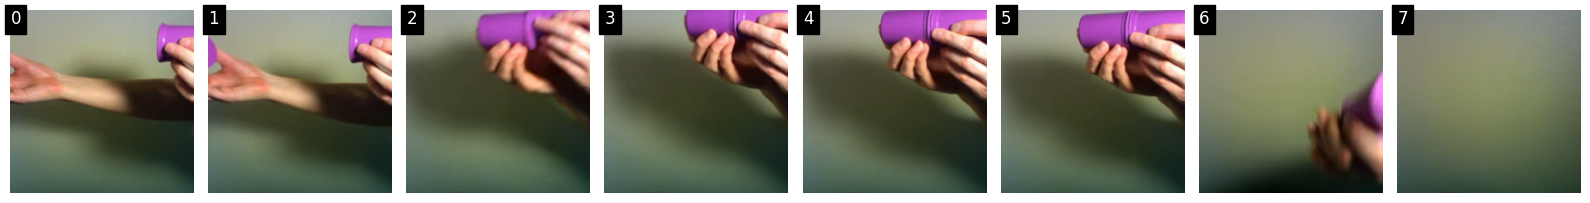

------------------------------------------------------------------------------------------


In [99]:
val_ds.load_cache_feats=False

for video_idx in per_timestep_video_indices:
    images, label, clip_indices, video_idx = val_ds.__getitem__(video_idx)
    print(f"video_idx: {video_idx.item()}")
    print(data[video_idx][0])
    print(idx2label[label])
    plt.plot(val_update_gates[video_idx].tolist()[0])
    visualize_frames(images[0])
    plt.show()
    print("---"*30)

#how can the first frame be so low

## sample video

path:/nas/manu/ssv2/20bn-something-something-v2/130688.webm
Covering something with something


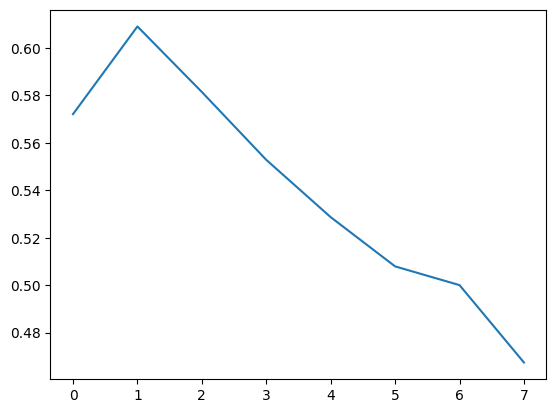

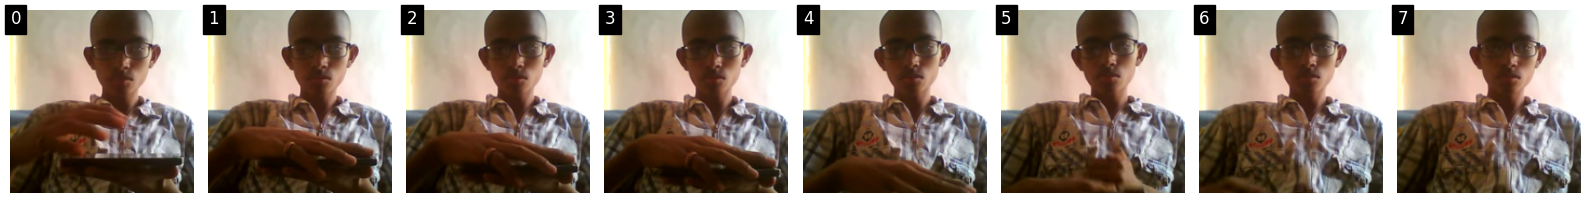

In [92]:
val_ds.load_cache_feats=False
video_idx = random.randint(0, val_ds.__len__())
images, label, clip_indices, video_idx = val_ds.__getitem__(video_idx)
print("path:" + data[video_idx][0])
print(idx2label[label])
plt.plot(val_update_gates[video_idx].tolist())
plt.show()
visualize_frames(images[0])

In [ ]:

## same frame repeated

##  what does the update value depend on


0.5230284929275513

## frame repeat

In [ ]:
from root.models.model import _build_model
device = utils._get_device()
args.load_cache_feats=False
model = _build_model(args, device)
model.eval()
checkpoint = torch.load(os.path.join(output_dir, checkpoint_name, "best.pt"), weights_only=False)
checkpoint['model'].update({f"dino.{k}":v for k,v in model.dino.state_dict().items()})

model.load_state_dict(checkpoint["model"])
model.collect_update_gates=True

In [58]:
#  --> has really high update gate value for first 2 timesteps
def repeated_video_exp(video_idx):
    val_ds.load_cache_feats=False
    images, label, clip_indices, video_idx = val_ds.__getitem__(video_idx)
    image = images[0][:,0,:,:]
    repeated_image = image.unsqueeze(1).repeat(1,8,1,1)
    print("original video")
    visualize_frames(images[0])
    print("repeated video")
    visualize_frames(repeated_image)

    with torch.no_grad():
        model(repeated_image.unsqueeze(0).cuda(), video_idx)
    print(idx2label[label])

    plt.plot(val_update_gates[video_idx], color="orange", label="original")
    plt.plot(model.val_update_gates[video_idx].tolist(), color="blue", label="repeated")
    plt.xlabel('timestep')
    plt.ylabel('update gate value')
    plt.legend()
    plt.show()

original video


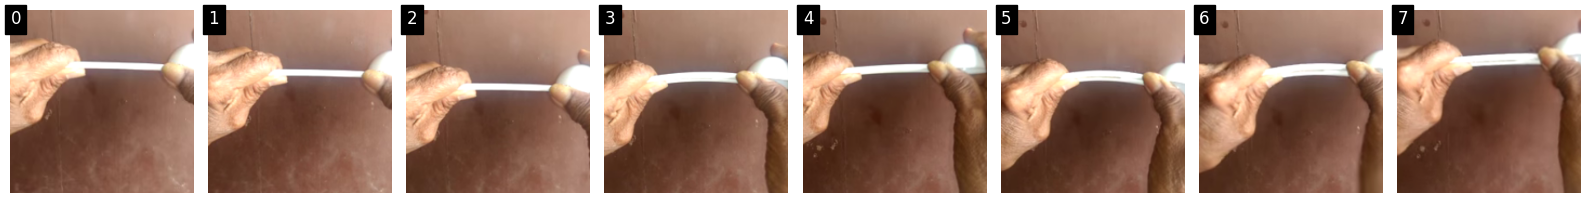

repeated video


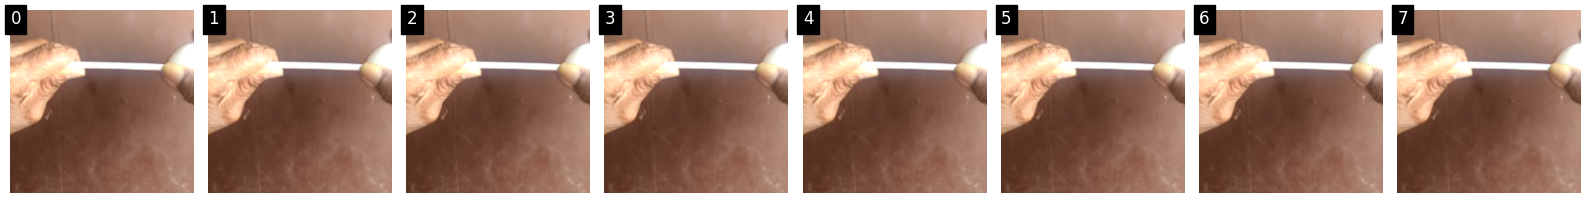

updating update gate information
Bending something so that it deforms


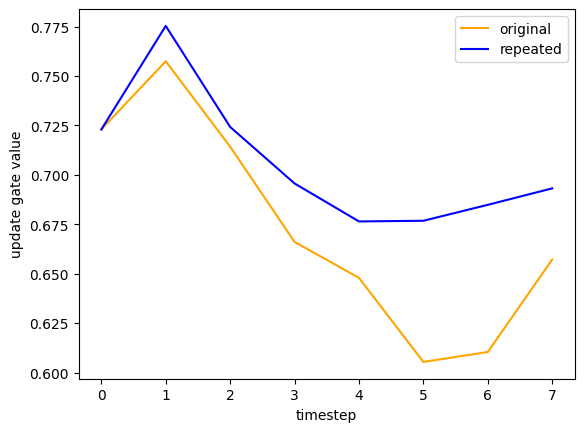

In [59]:
repeated_video_exp(24389)

original video


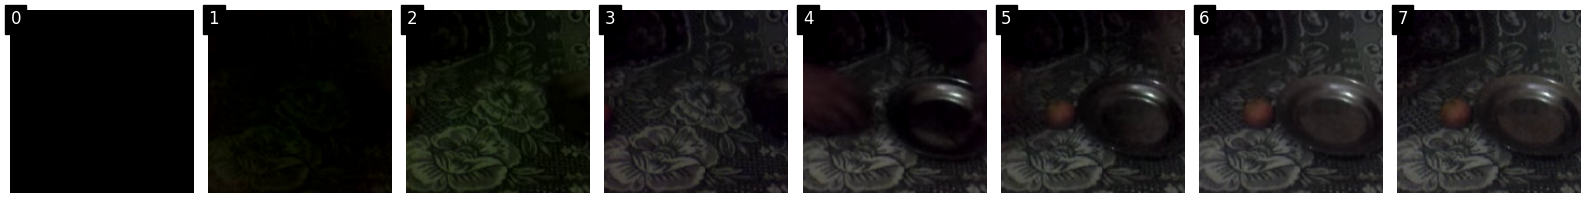

repeated video


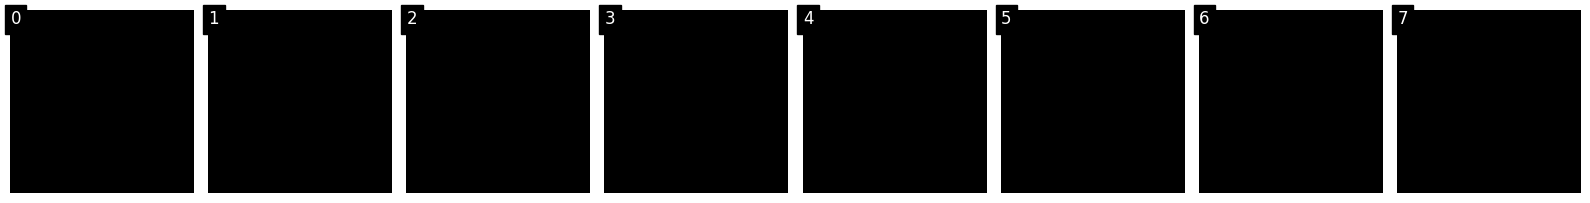

updating update gate information
Moving something and something closer to each other


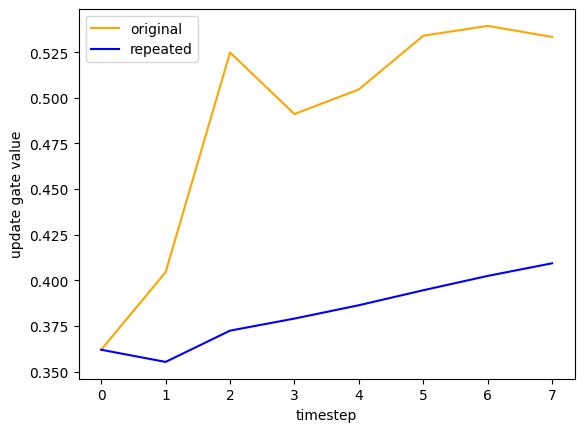

In [60]:
repeated_video_exp(4353)

original video


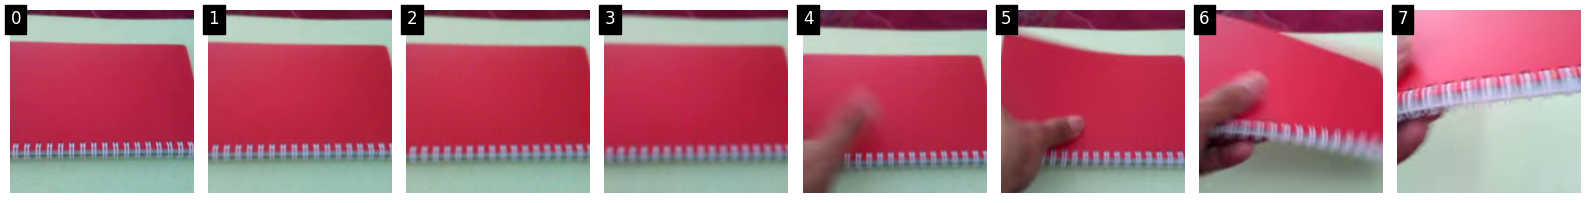

repeated video


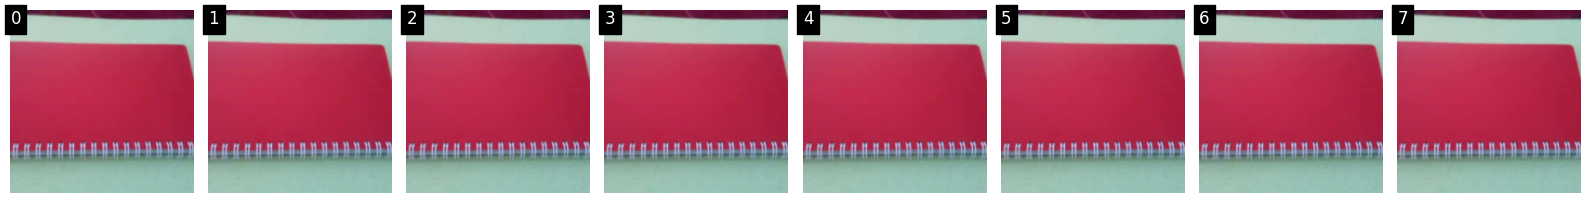

updating update gate information
Moving something up


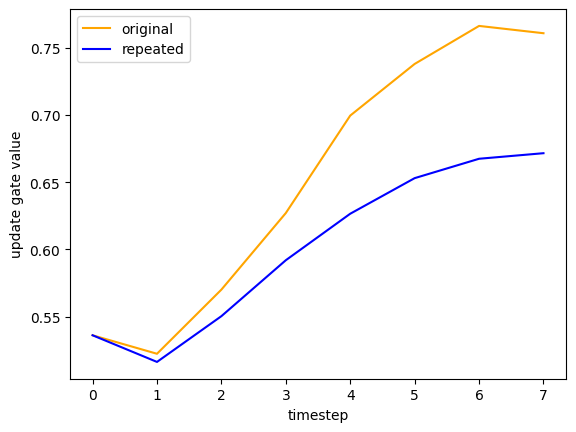

In [61]:
repeated_video_exp(15066)

### train an additive RNN i.e S_t + U * h  (S_t initialized with 0)

### think why that is important!!
